In [ ]:
import numpy as np
import random
np.random.seed(1)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
import os
import datetime
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import models
from sklearn.model_selection import train_test_split

In [ ]:
class GeneticAlgorithm:
    
    def mutation(self,chromosome,chance):
        index_of_mutated = random.randint(0, len(chromosome) - 1)
        try_to_mutate = random.randint(0, 100)
        if try_to_mutate <= chance:
            if chromosome[index_of_mutated] == 0:
                chromosome[index_of_mutated] = 1
            else:
                chromosome[index_of_mutated] = 0
        return chromosome
    
    def random_chromosome(self,length):
        return np.random.randint(0, 2, length).tolist()
    
    def get_num_of_perc(self,chromosome,kind):
        count = 0
        if kind == 1:
            for i in range(0,int(len(chromosome)),2):
                count += (2**i) * chromosome[i]
        else:  
            for i in range(1,int(len(chromosome)),2):
                count += 0.5 * chromosome[i]  
        return int(count)
    
    def make_new_chromosomes(self,chr1,chr2):
        border = random.randint(1, len(chr2) - 1)
        child1 = []
        child2 = []
        for i in range(0,len(chr2)):
            if i < border:
                child1.append(chr1[i])
                child2.append(chr2[i])
            else:
                child1.append(chr2[i])
                child2.append(chr1[i])
        return child1,child2
    
    def fitness_function(self, fit_1):
        sum_of_good = np.sum(fit_1.history['accuracy'])
        return sum_of_good / len(fit_1.history['accuracy'])
    
    def roulette_wheel_selection(self,scores):
        suma = np.sum(scores)
        procents = [] 
        for i in range(0,len(scores)):
            procents.append(scores[i]/suma)
        arr_of_chance = []
        
        for i in range(0,len(scores)):
            for j in range(0,int(scores[i] * 100)):
                arr_of_chance.append(i)
        
        return random.choice(arr_of_chance)
    
    
    def make_new_popul(self,chromosomes_population,score,chance_mut, X_train,y_train,val_stop,tb,X_test,y_test,n_pop):
        
        new_models_population = []
        new_score = []
        new_chromosomes_population = [] 


        for i in range(n_pop):
            new_models_population.append(models.Sequential())
            new_models_population[i].add(layers.InputLayer(input_shape=(8, 8, 1), name='input'))

        for i in range(0,int(n_pop/2)):
            first_index = self.roulette_wheel_selection(score)
            second_index = first_index
            while first_index  == second_index:
                second_index = self.roulette_wheel_selection(score)
                
            child1, child2 = self.make_new_chromosomes(chromosomes_population[first_index],chromosomes_population[second_index])
            
            child1 = self.mutation(child1,chance_mut)
            child2 = self.mutation(child2,chance_mut)

            new_chromosomes_population.append(child1)
            new_chromosomes_population.append(child2)


        for i in range(0,n_pop):
            new_models_population[i].add(layers.Flatten(name='flatten'))
            
            num_of_layers = self.get_num_of_perc(chromosomes_population[i],0)
            num_of_neurons = self.get_num_of_perc(chromosomes_population[i],1)
            
            if num_of_layers != 0 and num_of_neurons != 0:
                for j in range(0,1):
                    new_models_population[i].add(layers.Dense(num_of_neurons, activation='relu', name='hidden' + str(j)))
        
            new_models_population[i].add(layers.Dense(10, activation='softmax', name='output'))
            new_models_population[i].compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
            fit_1 = new_models_population[i].fit(X_train, y_train, 
                    epochs=15, 
                    callbacks=[val_stop, tb],
                    validation_data=(X_test, y_test))
            new_score.append(self.fitness_function(fit_1))
        

        return new_chromosomes_population,new_score,new_models_population
    
    
    
    def genetic_algorithm(self,n_gens, n_iter, n_pop, chance_mut, X_train,y_train,val_stop,tb,X_test,y_test):
        
        models_population = []
        chromosomes_population = []
        score = []



        new_models_population = []
        new_score = []
        new_chromosomes_population = [] 
        

        mean_on_popul = []
        best_in_popul = []


        for i in range(n_pop):
            models_population.append(models.Sequential())
            models_population[i].add(layers.InputLayer(input_shape=(8, 8, 1), name='input'))
        print(models_population)

        for i in range(0,n_pop):
            q = self.random_chromosome(n_gens)
            chromosomes_population.append(q)
        print(chromosomes_population)

        for i in range(0,n_pop):
            models_population[i].add(layers.Flatten(name='flatten'))
            
            num_of_layers = self.get_num_of_perc(chromosomes_population[i],0)
            num_of_neurons = self.get_num_of_perc(chromosomes_population[i],1)
            
            if (num_of_layers != 0 or num_of_layers != 1) and num_of_neurons != 0:
                for j in range(0,1):
                    models_population[i].add(layers.Dense(num_of_neurons, activation='relu', name='hidden' + str(j)))
            
            models_population[i].add(layers.Dense(10, activation='softmax', name='output'))
            models_population[i].compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
            print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
            fit_1 = models_population[i].fit(X_train, y_train, 
                    epochs=15, 
                    callbacks=[val_stop, tb],
                    validation_data=(X_test, y_test))
            score.append(self.fitness_function(fit_1))
        print(models_population)
        print(score)


        print("start population")
        print(chromosomes_population)
        print("start score")
        print(score)
        print()

        
        mean_on_popul.append(np.sum(score)/len(score))
        best_in_popul.append(np.amax(np.array(score)))
        
        for i in range(n_iter):
            new_chromosomes_population,new_score,new_models_population = self.make_new_popul(chromosomes_population,score,chance_mut, X_train,y_train,val_stop,tb,X_test,y_test,n_pop)
            
            if abs(np.sum(new_score)/10 - np.sum(score)/10) < 0.01:    
                print("population " + str(i))
                print(new_chromosomes_population)
                print("population scores " + str(j))
                print(new_score)
                print()

                models_population = new_models_population
                chromosomes_population = new_chromosomes_population
                score = new_score
                
                mean_on_popul.append(np.sum(score)/len(score))
                best_in_popul.append(np.amax(np.array(score)))
                self.show_learning(mean_on_popul,best_in_popul)
                return models_population, chromosomes_population, score   


            print("population " + str(i))
            print(new_chromosomes_population)
            print("population scores " + str(i))
            print(new_score)
            print()
            
            models_population = new_models_population
            chromosomes_population = new_chromosomes_population
            score = new_score

            mean_on_popul.append(np.sum(score)/len(score))
            best_in_popul.append(np.amax(np.array(score)))

        self.show_learning(mean_on_popul,best_in_popul)
        return models_population, chromosomes_population, score   
        
    def show_learning(self,mean_on_popul,best_in_popul):
        plt.figure(figsize=(8, 5))
        plt.plot(mean_on_popul, '-', label='mean_on_popul')
        plt.plot(best_in_popul, '-', label='best_in_popul')
        plt.xlabel("step of genetic algorithm")
        plt.legend()
        plt.show()

In [ ]:
X, y = load_digits(return_X_y=True)

In [ ]:
MinMaxScaler(copy=False).fit_transform(X)

array([[0.    , 0.    , 0.3125, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.625 , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 1.    , 0.5625, 0.    ],
       ...,
       [0.    , 0.    , 0.0625, ..., 0.375 , 0.    , 0.    ],
       [0.    , 0.    , 0.125 , ..., 0.75  , 0.    , 0.    ],
       [0.    , 0.    , 0.625 , ..., 0.75  , 0.0625, 0.    ]])

In [ ]:
X = X.reshape(X.shape[0], 8, 8, 1).astype('float32')

In [ ]:
y = to_categorical(y)
y.shape[0], y.shape[1], y

(1797, 10, array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 1., 0.]], dtype=float32))

In [ ]:
X.dtype, X.shape, X.max(), y.shape

(dtype('float32'), (1797, 8, 8, 1), 1.0, (1797, 10))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    stratify=y, 
                                                    random_state=42)

%load_ext tensorboard

val_stop = EarlyStopping(monitor='val_loss', patience=5)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb = TensorBoard(logdir, histogram_freq=1)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1347, 8, 8, 1), (450, 8, 8, 1), (1347, 10), (450, 10))

In [ ]:
gen = GeneticAlgorithm()

[<keras.engine.sequential.Sequential object at 0x7fcaaa808d50>, <keras.engine.sequential.Sequential object at 0x7fcaaca410d0>, <keras.engine.sequential.Sequential object at 0x7fcaaa481890>, <keras.engine.sequential.Sequential object at 0x7fcaaa481ed0>, <keras.engine.sequential.Sequential object at 0x7fcaaa489e50>, <keras.engine.sequential.Sequential object at 0x7fcaaa490990>, <keras.engine.sequential.Sequential object at 0x7fcaaa490e50>, <keras.engine.sequential.Sequential object at 0x7fcaaa496f50>, <keras.engine.sequential.Sequential object at 0x7fcaaa7929d0>, <keras.engine.sequential.Sequential object at 0x7fcaaa4a6510>]
[[1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0], [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0], [0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0], [1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1], [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 

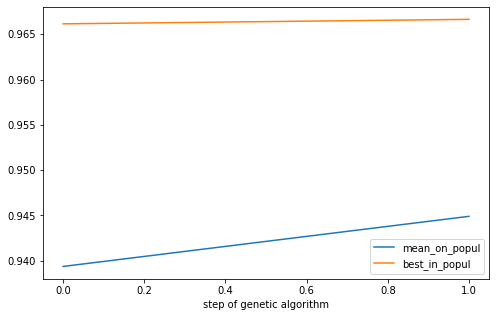

In [ ]:
models_population, chromosomes_population, score = gen.genetic_algorithm(20, 10, 10, 10, X_train,y_train,val_stop,tb,X_test,y_test)

In [ ]:
best_model = models_population[np.array(score).argmax(axis=0)] 

In [ ]:
fit_1 = best_model.fit(X_train, y_train, 
                    epochs=15, 
                    # batch_size=32,
                    callbacks=[val_stop, tb],
                    validation_data=(X_test, y_test))

Epoch 1/15
43/43 [==============================] - 1s 31ms/step - loss: 0.0206 - accuracy: 0.9955 - val_loss: 0.0849 - val_accuracy: 0.9733
Epoch 2/15
43/43 [==============================] - 1s 32ms/step - loss: 0.0215 - accuracy: 0.9941 - val_loss: 0.0743 - val_accuracy: 0.9778
Epoch 3/15
43/43 [==============================] - 1s 32ms/step - loss: 0.0088 - accuracy: 0.9978 - val_loss: 0.2673 - val_accuracy: 0.9356
Epoch 4/15
43/43 [==============================] - 1s 30ms/step - loss: 0.0095 - accuracy: 0.9985 - val_loss: 0.1008 - val_accuracy: 0.9800
Epoch 5/15
43/43 [==============================] - 1s 32ms/step - loss: 0.0191 - accuracy: 0.9941 - val_loss: 0.1152 - val_accuracy: 0.9667
Epoch 6/15
43/43 [==============================] - 1s 33ms/step - loss: 0.0151 - accuracy: 0.9970 - val_loss: 0.0777 - val_accuracy: 0.9844
Epoch 7/15
43/43 [==============================] - 1s 31ms/step - loss: 8.0986e-04 - accuracy: 1.0000 - val_loss: 0.0868 - val_accuracy: 0.9844


In [ ]:
y_pred_1 = fit_1.model.predict(X_test)

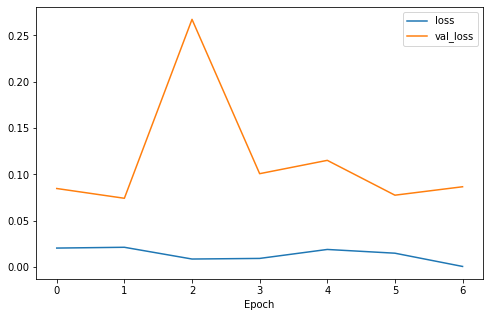

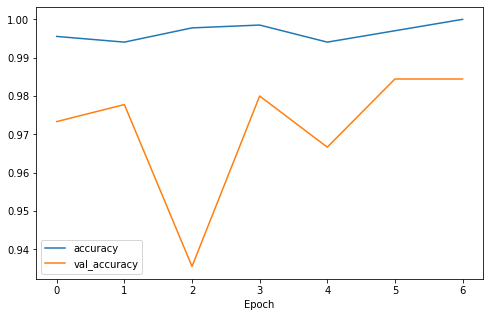

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(fit_1.history['loss'], '-', label='loss')
plt.plot(fit_1.history['val_loss'], '-', label='val_loss')
plt.xlabel("Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(fit_1.history['accuracy'], '-', label='accuracy')
plt.plot(fit_1.history['val_accuracy'], '-', label='val_accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

array([[45,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 46,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 44,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2, 44,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 45,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 44,  0,  0,  0,  2],
       [ 0,  0,  0,  0,  0,  0, 45,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 45,  0,  0],
       [ 0,  1,  0,  0,  1,  0,  0,  1, 40,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 45]])

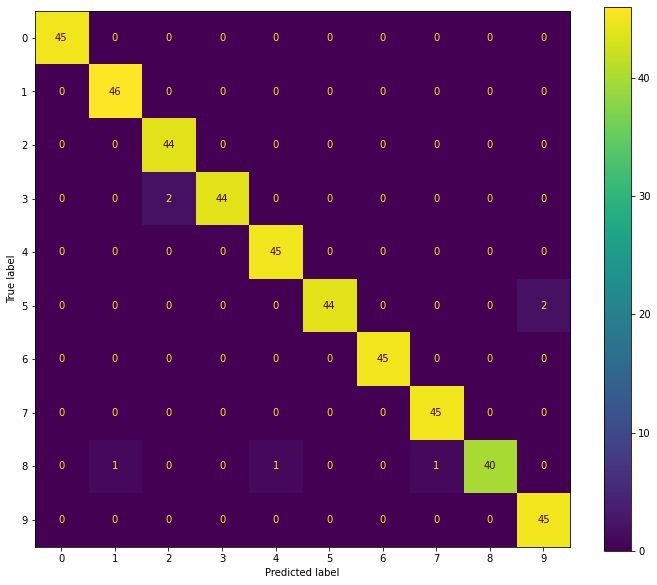

In [ ]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_1, axis=1))
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(12, 10))
cmp.plot(ax=ax)
cm

In [ ]:
len(y_test)

450

In [ ]:
cm.sum()

450